In [1]:
import torch
device = torch.device("cpu")

## Explore MNIST Dataset
The MNIST dataset contains 60,000 grayscale images of size $28\times28\times1$.
These images contain number from 0-9, and the task is to predict which number the image shows.

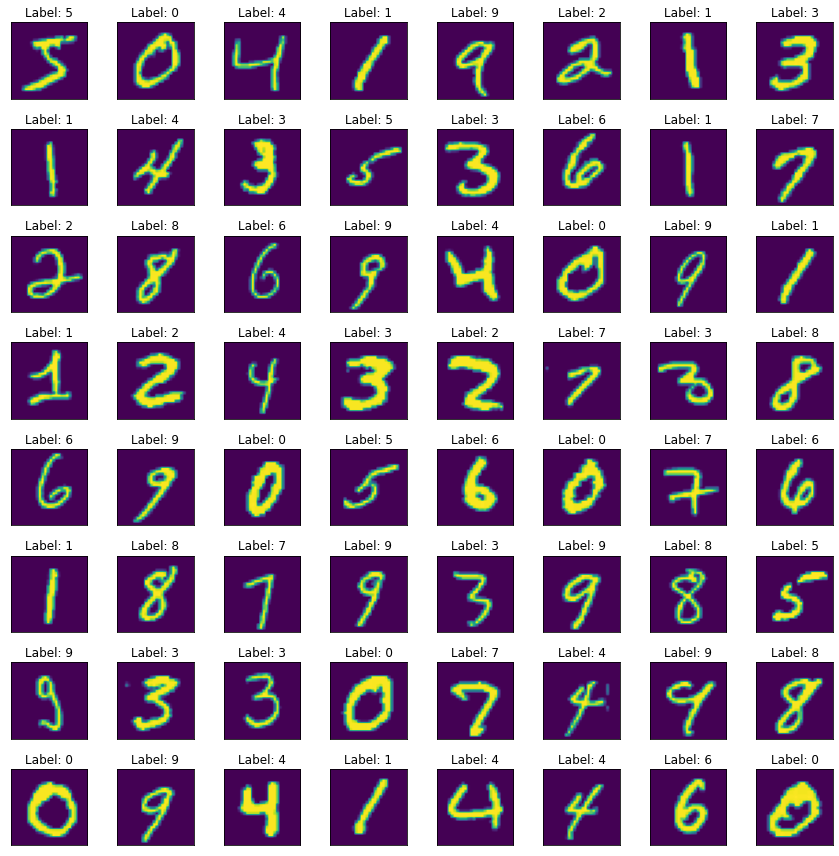

In [2]:
import matplotlib.pyplot as plt
from torchvision import datasets

train_ds = datasets.MNIST('MNIST', download=True, train=True)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    x, y = train_ds[i]
    axs[i].imshow(x)
    axs[i].set_title(f"Label: {y}")
    axs[i].xaxis.set_visible(False)
    axs[i].yaxis.set_visible(False)


plt.tight_layout()
plt.show()

## Create a Model
Now, lets create a CNN to classify the digits

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    """Custom module for a simple convnet classifier"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 128, kernel_size=3)
        self.dropout = nn.Dropout()
        self.fc1 = nn.Linear(128, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # input is bx28x28x1
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.conv3(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # bx128x1x1 -> bx128
        x = x.view(-1, 128)
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return x

## Setup dataset and Preprocessing

In [4]:
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize(28),
    transforms.ToTensor(),
])

train_ds = datasets.MNIST('MNIST', download=True, train=True, transform=transform)
test_ds = datasets.MNIST('MNIST', download=True, train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)

## Train on the MNIST Training-Set

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# create model and optimizer
model = CNN().to(device)
opti = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 2

train_losses = []
test_losses = []

def train(epoch):
    model.train() # set model in training mode (need this because of dropout)

    # dataset API gives us pythonic batching
    for n, (x, y) in enumerate(train_loader):
        x = x.to(device)
        y = y.to(device)

        # forward pass, calculate loss and backprop!
        opti.zero_grad()
        y_hat = model(x)
        loss = F.cross_entropy(y_hat, y)
        loss.backward()
        opti.step()

        if n % 100 == 0:
            print(f"Loss: {loss.item()}")
    train_losses.append(loss.item())

def test(epoch):
    model.eval() # set model in inference mode (need this because of dropout)
    test_loss = 0
    correct = 0

    with torch.no_grad(): # we do not require gradients
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)

            y_hat = model(x)
            loss = F.cross_entropy(y_hat, y)
            pred = y_hat.max(dim=1).indices # get the index of the max log-probability
            correct += pred.eq(y).cpu().sum()
            test_loss += loss

    test_loss /= len(test_loader) # loss function already averages over batch size
    test_losses.append(test_loss)
    accuracy = correct / len(test_ds)
    print(f"Test set: Average loss: {loss:.4f}, Accuracy: {correct}/{len(test_ds)} ({accuracy:.2%})")

for epoch in range(n_epochs):
    print(f"Epoch {epoch}")
    train(epoch)
    test(epoch)

Epoch 0
Loss: 2.2955498695373535
Loss: 0.9385124444961548
Loss: 0.5341733694076538
Loss: 0.40615808963775635
Loss: 0.428623229265213
Test set: Average loss: 0.0475, Accuracy: 9475/10000 (94.75%)
Epoch 1
Loss: 0.32848379015922546
Loss: 0.19549991190433502
Loss: 0.20658384263515472
Loss: 0.1986784040927887
Loss: 0.2729513645172119
Test set: Average loss: 0.0340, Accuracy: 9624/10000 (96.24%)


## Plot the Learning Process

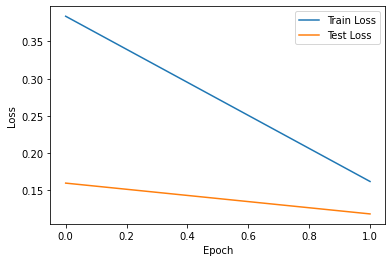

In [19]:
import matplotlib.pyplot as plt
import numpy as np
# n_epochs = 2
# train_losses= [1,2]
# test_losses = [3,4]
plt.plot(range(n_epochs),train_losses,label = "Train Loss")
plt.plot(range(n_epochs),test_losses, label = "Test Loss")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [16]:
train_losses

[2.296424388885498,
 1.0465174913406372,
 0.4499332010746002,
 0.2919495105743408,
 0.3316839039325714,
 0.3126097321510315,
 0.24856474995613098,
 0.1726491004228592,
 0.13515719771385193,
 0.23616768419742584]

## Test on the MNIST Test-Set
Our model achieves $\approx 98 \%$ accuracy on the test set.
Let us inspect some predictions.

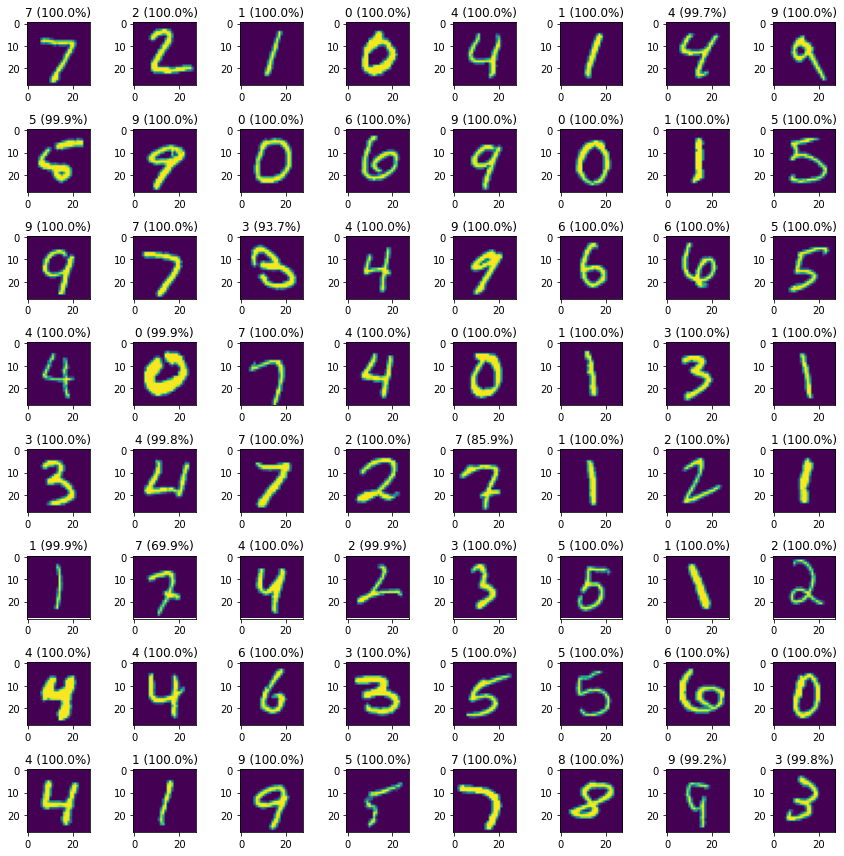

In [7]:
from torchvision.transforms.functional import to_pil_image
model.eval()

for mnist_images, y in test_loader:
    with torch.no_grad():
        y_hat = model(mnist_images.to(device))
        break

mnist_values, mnist_indices = y_hat.softmax(dim=1).max(dim=1)

fix, axs = plt.subplots(8,8, figsize=(12,12))
axs = axs.flatten()

for i in range(64):
    axs[i].imshow(to_pil_image(mnist_images[i]))
    axs[i].set_title(f"{mnist_indices[i]} ({mnist_values[i]:.1%})")
    axs[i].xaxis.set_visible(True)
    axs[i].yaxis.set_visible(True)

plt.tight_layout()
plt.show()